In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
from datetime import datetime, date
df.index = pd.to_datetime(df.Date, format = '%d/%m/%Y', )
df = df.drop(['Date'], axis=1)
df.head()

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [2]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

In [3]:
# df_downsampled = df[['Date',
#                      'Depth_to_Groundwater',
#                      'Temperature',
#                      'Drainage_Volume',
#                      'River_Hydrometry'
#                      ]].resample('7D', on='Date').mean().reset_index(drop=False)
#
# df_downsampled['Rainfall'] = df[['Date',
#                                  'Rainfall'
#                                  ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]
# uni = df_downsampled.drop(['Rainfall', 'Temperature', 'Drainage_Volume', 'River_Hydrometry'], axis=1)
depth = df['Depth_to_Groundwater']
temp = df['Temperature']
rain = df['Rainfall']
drain = df['Drainage_Volume']
hydro = df['River_Hydrometry']

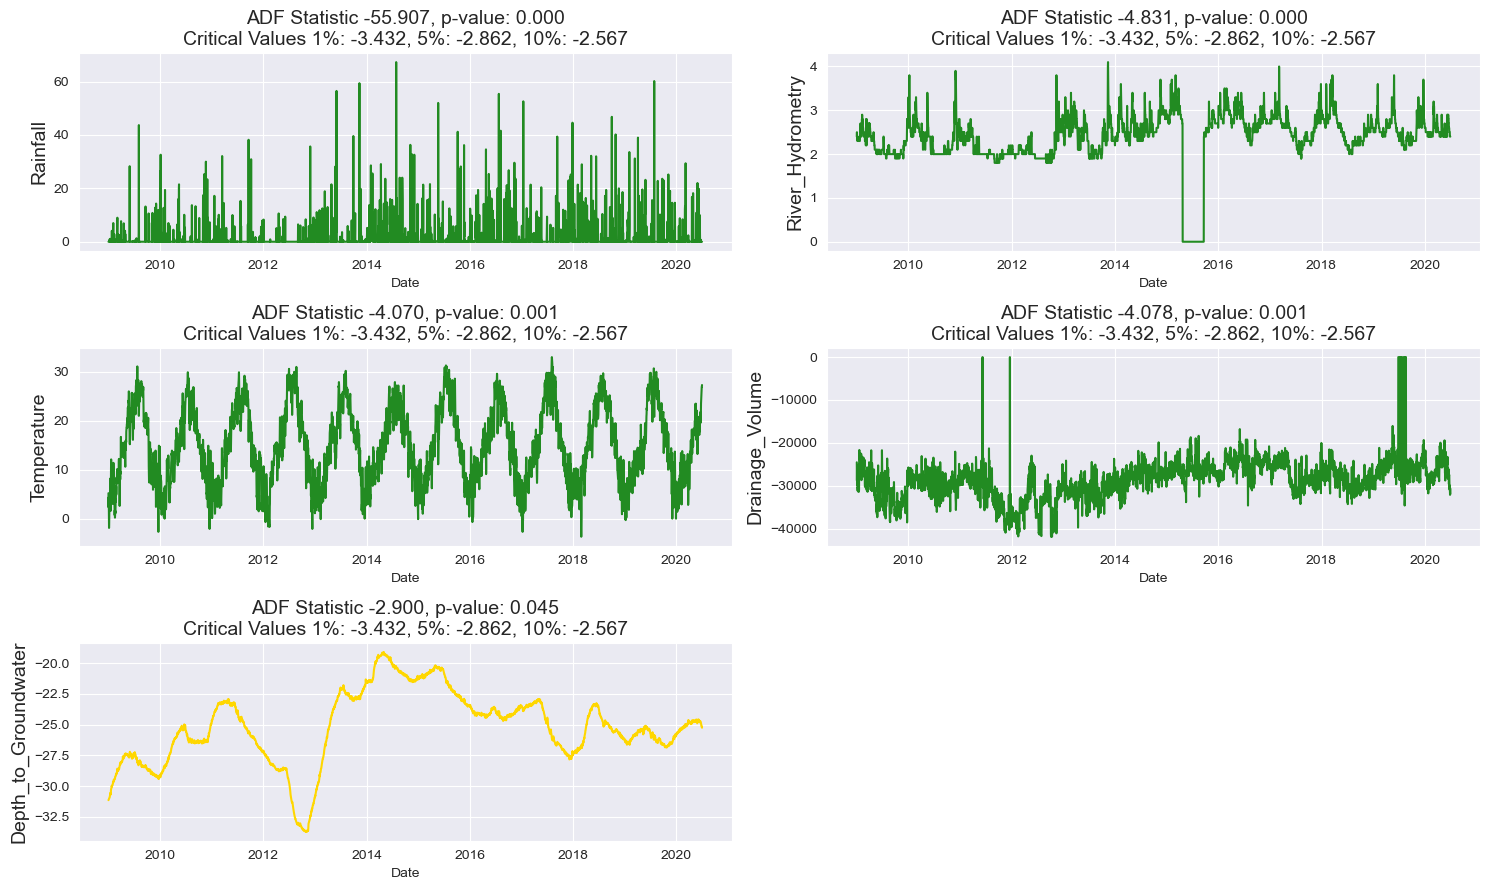

In [4]:
from statsmodels.tsa.stattools import adfuller
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=df.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df.Rainfall.values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df.Temperature.values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df.River_Hydrometry.values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df.Drainage_Volume.values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df.Depth_to_Groundwater.values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

In [5]:
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("Dataset: ", dataset.name)
    print("1. ADF: ",dftest[0])
    print("2. P-Value: ", dftest[1])
    print("3. Num Of Lags: ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values:")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)


In [6]:
for col in range(df.shape[1]):
    adf_test(df.iloc[:,col])

Dataset:  Rainfall
1. ADF:  -55.90692992415628
2. P-Value:  0.0
3. Num Of Lags:  0
4. Num Of Observations Used For ADF Regression: 4198
5. Critical Values:
	 1% :  -3.4319086715288334
	 5% :  -2.862228735313844
	 10% :  -2.5671366196112806
Dataset:  Depth_to_Groundwater
1. ADF:  -2.8998369955680428
2. P-Value:  0.04536695595343398
3. Num Of Lags:  28
4. Num Of Observations Used For ADF Regression: 4170
5. Critical Values:
	 1% :  -3.4319191438819407
	 5% :  -2.8622333615468443
	 10% :  -2.567139082403142
Dataset:  Temperature
1. ADF:  -4.069936867799228
2. P-Value:  0.0010854767723929362
3. Num Of Lags:  29
4. Num Of Observations Used For ADF Regression: 4169
5. Critical Values:
	 1% :  -3.4319195204978277
	 5% :  -2.8622335279191637
	 10% :  -2.567139170972099
Dataset:  Drainage_Volume
1. ADF:  -4.0784971655817435
2. P-Value:  0.0010508967784143373
3. Num Of Lags:  30
4. Num Of Observations Used For ADF Regression: 4168
5. Critical Values:
	 1% :  -3.431919897294544
	 5% :  -2.8622336

In [7]:
def split_data(df):
    testSize = 100
    train= df.iloc[:-testSize]
    test= df.iloc[-testSize:]
    return train, test
train_rain, test_rain = split_data(rain)
train_drain, test_drain = split_data(drain)
train_depth, test_depth = split_data(depth)
train_hydro, test_hydro = split_data(hydro)
train_temp, test_temp = split_data(temp)
train = [train_rain,train_depth,train_temp,train_drain,train_hydro]
test = [test_rain,test_depth,test_temp,test_drain,test_hydro]

In [108]:
rain.iloc[[4]]

Date
2009-01-05    0.0
Name: Rainfall, dtype: float64

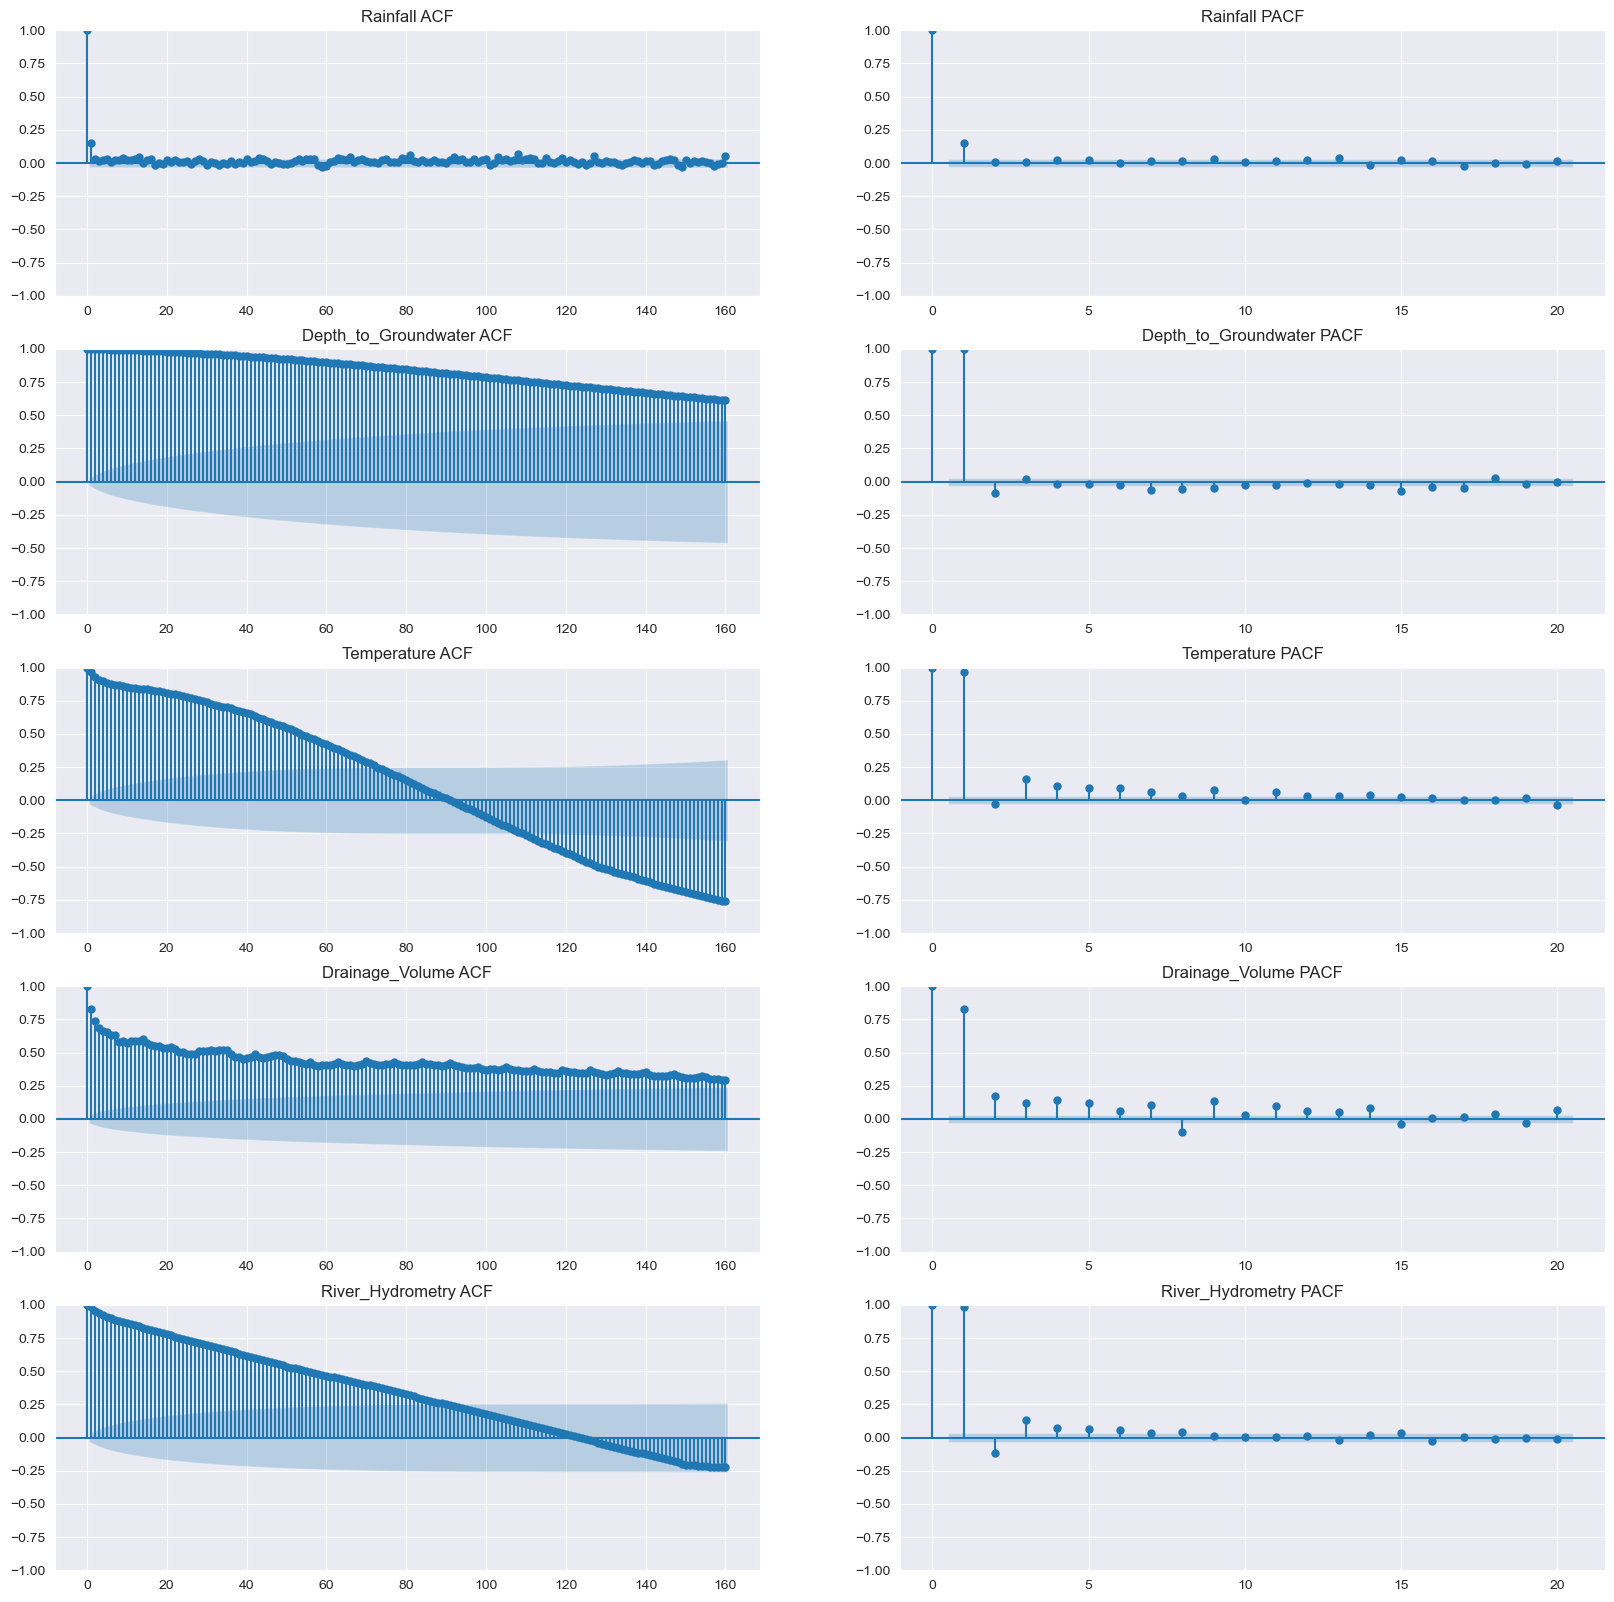

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

for col in range(df.shape[1]):
    plot_acf(train[col], lags=160, title=train[col].name + ' ACF', ax=ax[col,0]);
    plot_pacf(train[col], lags=20, title=train[col].name + ' PACF', ax=ax[col,1]);


In [11]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
def get_order(df):
    stepwise_fit = auto_arima(df, suppress_warnings=True)
    return stepwise_fit.order
order = []
for i in range(5):
    order.append(get_order(train[i]))

C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was 

In [12]:
def fit_arima(df, index):
    model=ARIMA(df,order=order[index])
    model=model.fit()
    return model
model_rain = fit_arima(train_rain, 0)
model_drain = fit_arima(train_drain, 1)
model_temp = fit_arima(train_temp, 2)
model_hydro = fit_arima(train_hydro, 3)
model_depth = fit_arima(train_depth, 4)

C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was 

In [13]:
models= np.array([model_rain,model_depth,model_temp,model_drain,model_hydro])

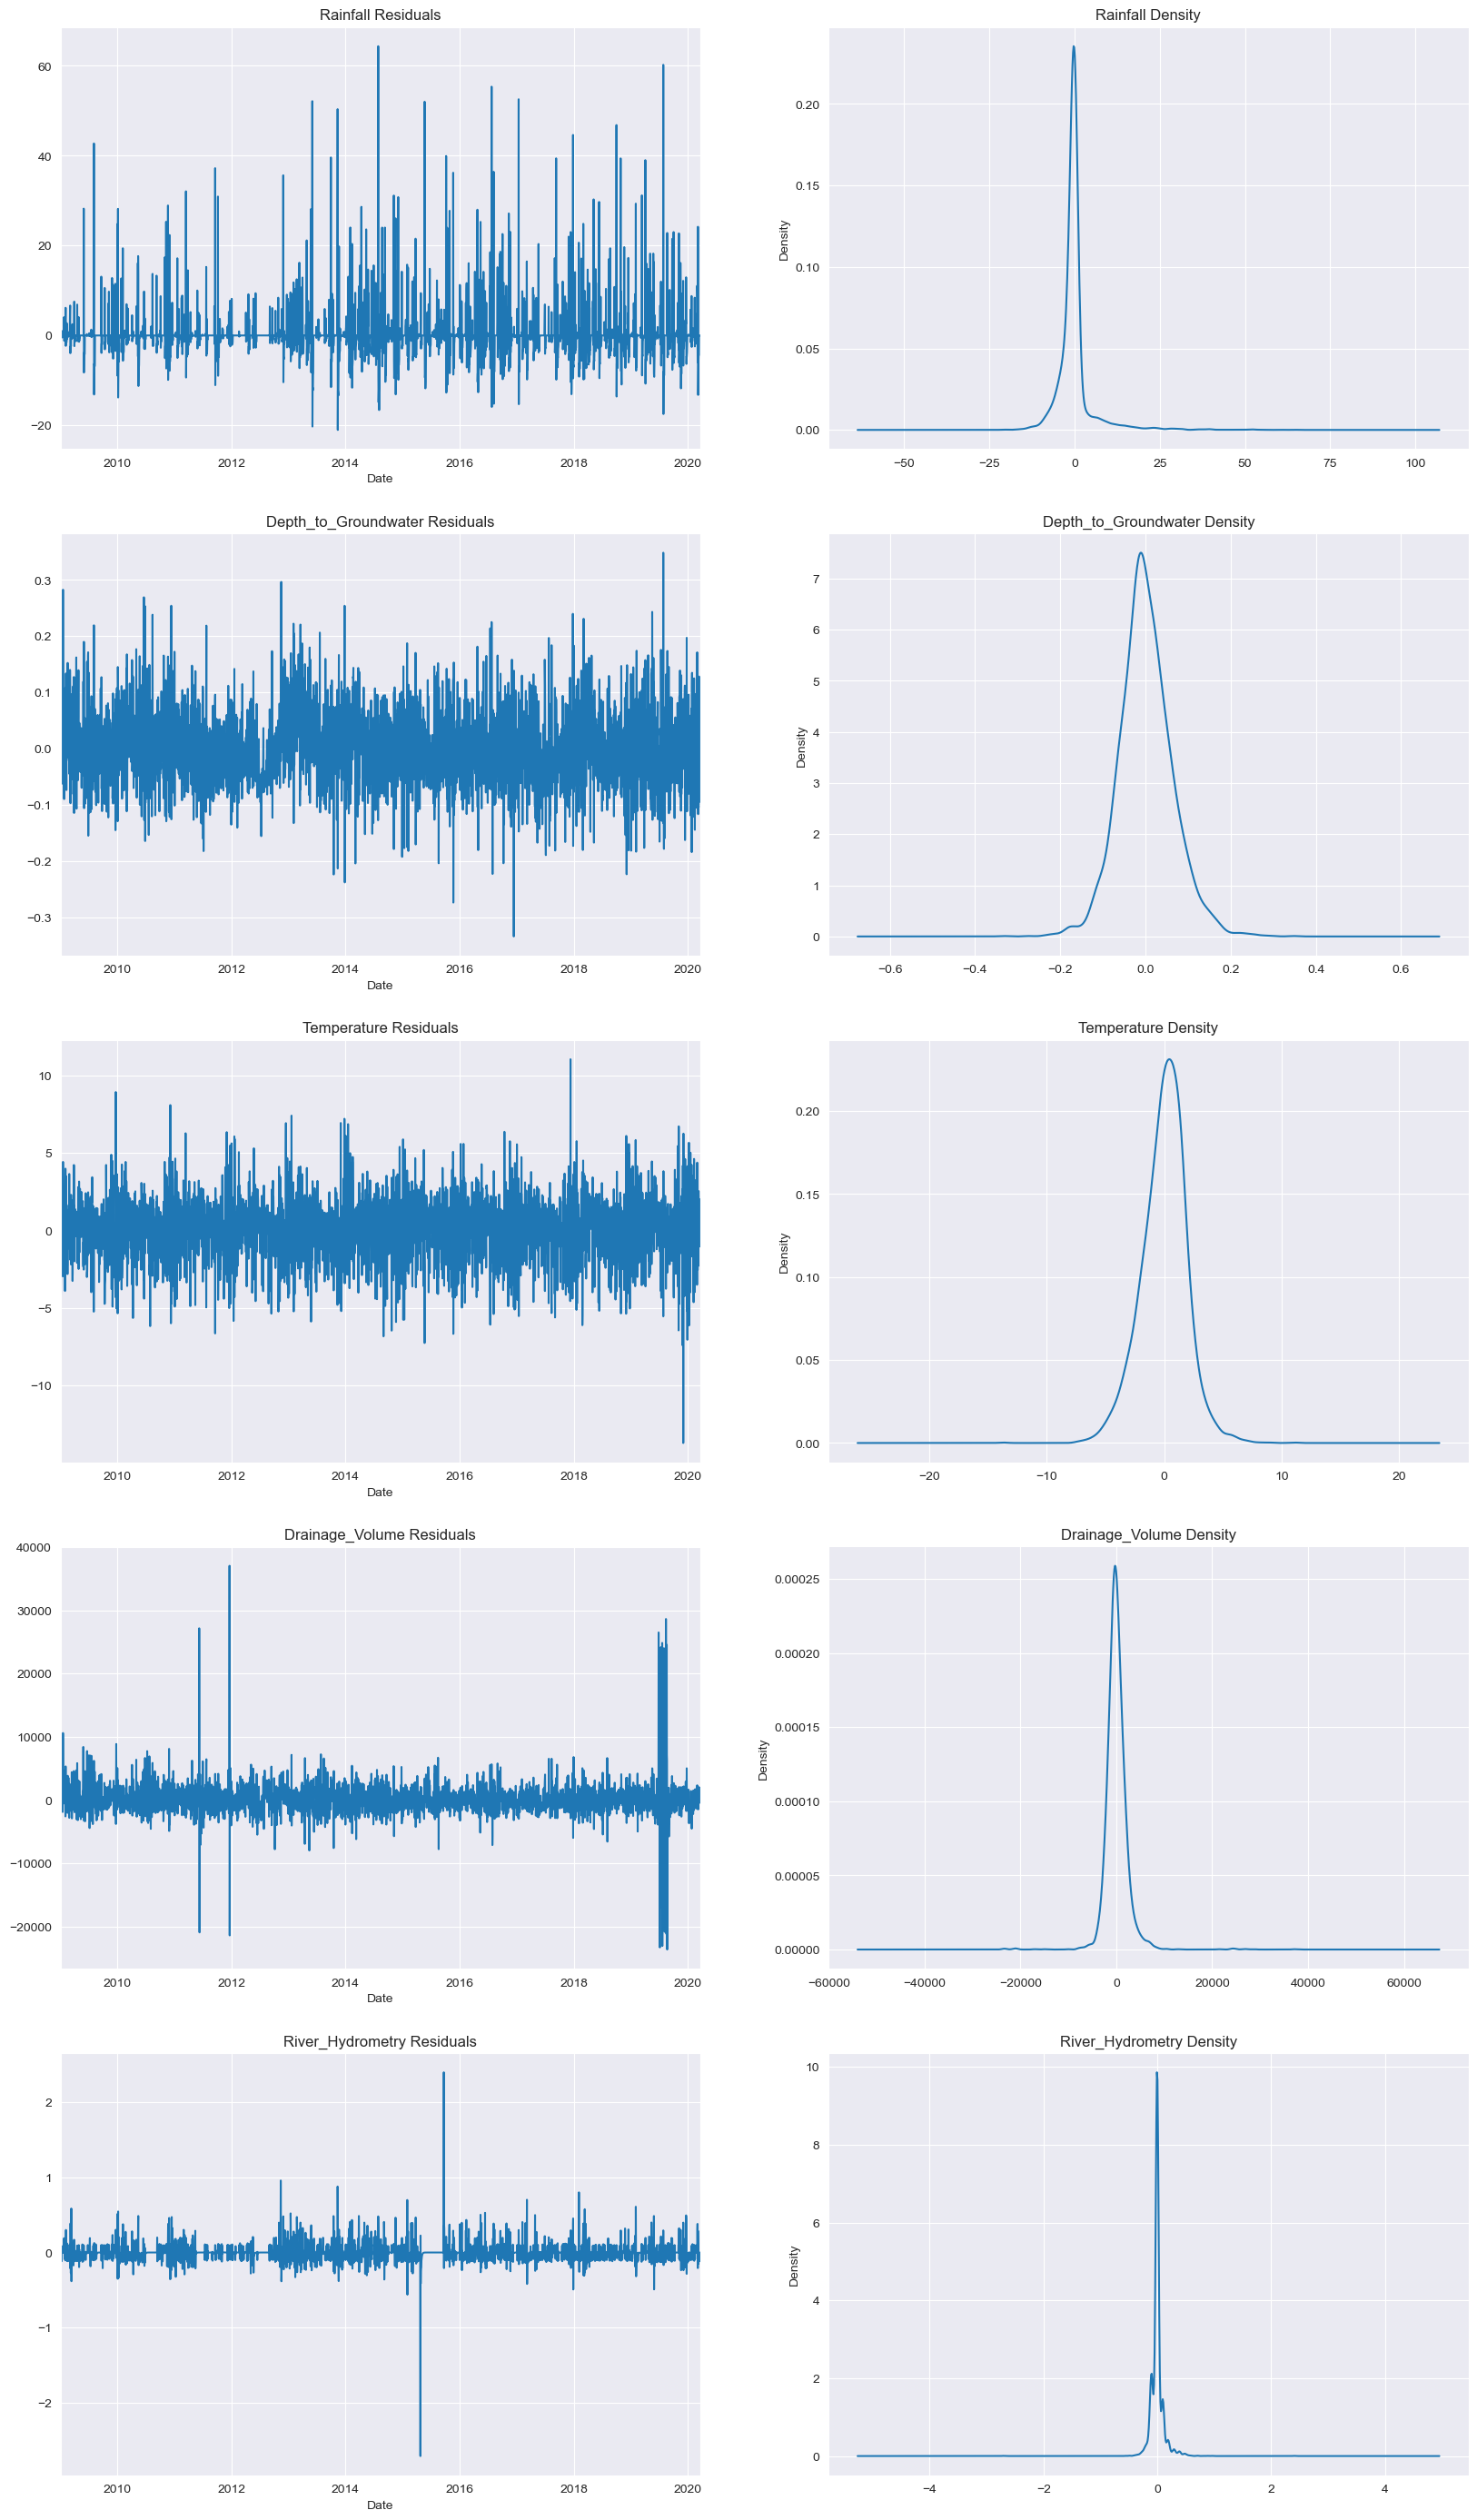

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 35))
for model in range(0,5):
    residuals =models[model].resid[1:]
    residuals.plot(title= train[model].name + ' Residuals', ax=ax[model,0])
    residuals.plot(title=train[model].name + ' Density', kind='kde', ax=ax[model,1])
plt.show()

In [15]:
pres = [None] * 5
pre = models[0].predict()
pres[1] = pre
pres[1]

2009-01-01    0.000000e+00
2009-01-02    0.000000e+00
2009-01-03    0.000000e+00
2009-01-04    0.000000e+00
2009-01-05    0.000000e+00
                  ...     
2020-03-18    9.500631e-17
2020-03-19   -1.856921e-18
2020-03-20   -1.114350e-33
2020-03-21   -8.546808e-34
2020-03-22   -6.854663e-34
Freq: D, Name: predicted_mean, Length: 4099, dtype: float64

4198

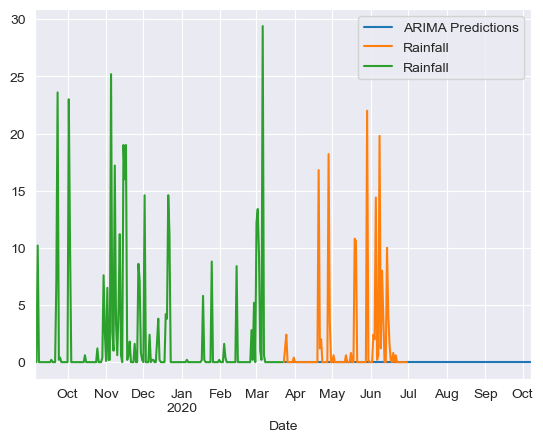

In [16]:
start=len(train[0])
end=len(train[0])+len(test[0])-1
p=models[0].predict(start=start,end=end+100,typ='levels').rename('ARIMA Predictions')
p.plot(legend=True)
test[0].plot(legend=True)
train[0][-200:].plot(legend=True)


In [17]:
end

4198

KeyError: 0

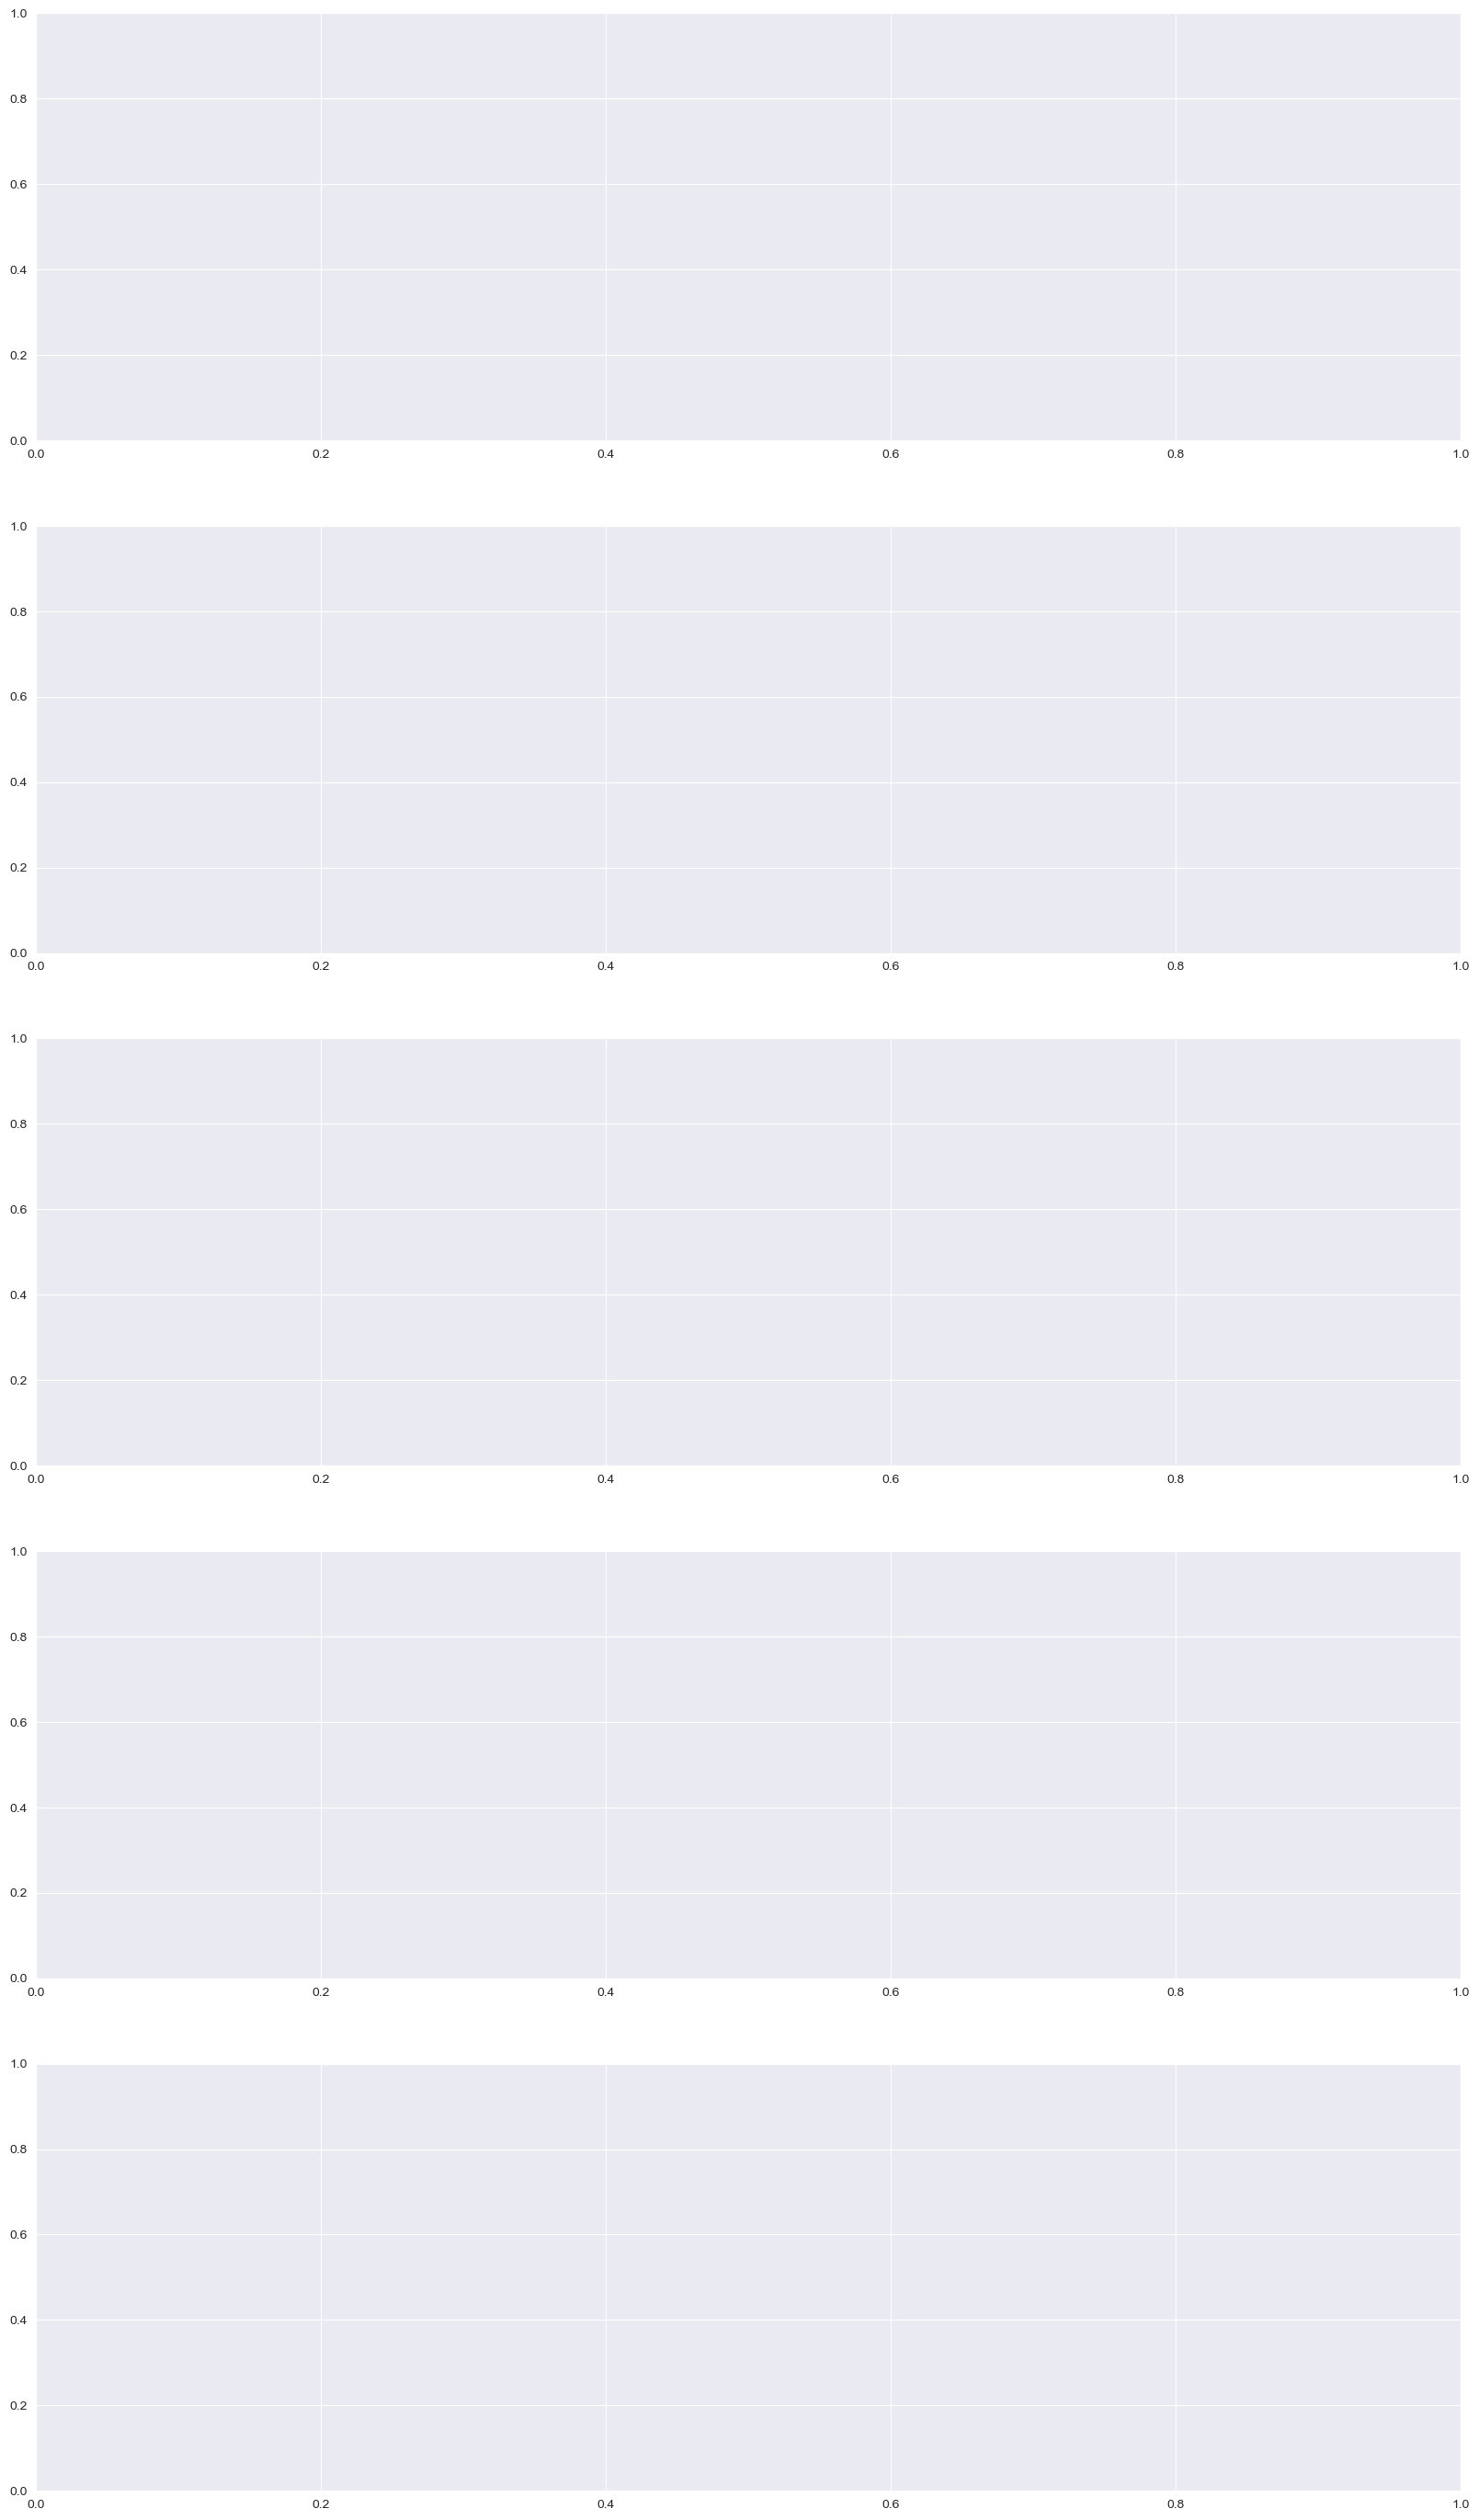

In [107]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
pred = [None] * 5
#forecast_test = [None] * 5
for model in range(0,5):
    start=len(train[model])
    end=len(train[model])+len(test[model])-1
    pred[model]=models[model].predict(start=start,end=end + 100,typ='levels').rename('ARIMA Predictions')
    #forecast_test[model] = models[model].forecast(len(test[model]))
    pred[model].plot(ax = ax[model], legend=True)
    test[model].plot(ax = ax[model], legend=True)
    train[model][-100:].plot(ax = ax[model], legend=True)
    #forecast_test[model].plot(ax = ax[model], legend=True)
plt.show()

In [86]:
# Rolling ARIMA algorithm
import math
def arima_roll(df, index):
    train, test = split_data(df)
    history = train.copy()
    predictions = []
    for t in range(len(test)):
        model = fit_arima(history, index)
        hat = model.forecast()
        predictions.append(hat)
        history = history.append(pd.Series(test[t], index=[test.index[t]]))

    return history, predictions

In [87]:
preds_roll = [[]]
history_roll = [[]]
RMSE = []
preds_roll, history_roll = arima_roll(depth, 0)

C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\ARIMA\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was 

In [89]:
preds_roll

2009-01-01   -31.14
2009-01-02   -31.11
2009-01-03   -31.07
2009-01-04   -31.05
2009-01-05   -31.01
              ...  
2020-06-26   -25.07
2020-06-27   -25.11
2020-06-28   -25.19
2020-06-29   -25.18
2020-06-30   -25.25
Length: 4199, dtype: float64

<Axes: >

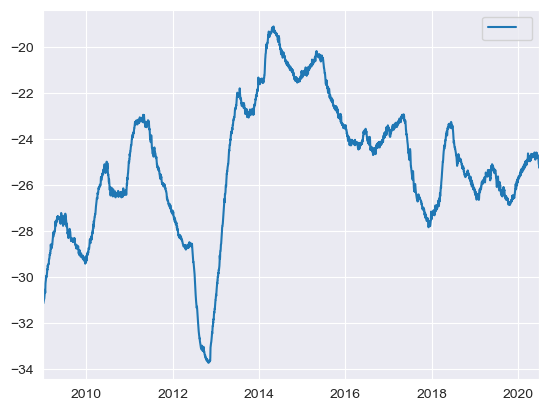

In [101]:
preds_roll.plot(legend=True)


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test.mean()
rmse=sqrt(mean_squared_error(pred,test))
print(rmse)